In [1]:
import mitsuba as mi
import drjit as dr
import matplotlib.pyplot as plt
import numpy as np

mi.set_variant("scalar_rgb")

 - Warning: compute capability of device too low, skipping ..


In [2]:
def spherical_to_cartesian(v):
    v = mi.Vector3f(v)
    sin_theta, cos_theta = dr.sincos(v.y)
    sin_phi, cos_phi = dr.sincos(v.z)
    return mi.Vector3f(
        v.x * sin_theta * cos_phi, v.x * sin_theta * sin_phi, v.x * cos_theta
    )

print(spherical_to_cartesian([1, dr.pi / 2, 0]))
print(spherical_to_cartesian([1, dr.pi / 2, dr.pi / 2]))
print(spherical_to_cartesian([1, dr.pi / 2, dr.pi / 4]))
print(spherical_to_cartesian([1, dr.pi / 2, 3 * dr.pi / 4]))
print(spherical_to_cartesian([1, dr.pi / 2, 0]))
print(spherical_to_cartesian([1, dr.pi / 4, 0]))
print(spherical_to_cartesian([1, 0, 0]))

[1.0, 0.0, -4.371138828673793e-08]
[-4.371138828673793e-08, 1.0, -4.371138828673793e-08]
[0.7071067690849304, 0.7071067690849304, -4.371138828673793e-08]
[-0.7071067690849304, 0.7071067690849304, -4.371138828673793e-08]
[1.0, 0.0, -4.371138828673793e-08]
[0.7071067690849304, 0.0, 0.7071067690849304]
[0.0, 0.0, 1.0]


In [3]:
def cartesian_to_spherical(v):
    v = mi.Vector3f(v)
    r = dr.norm(v)
    theta = dr.acos(v.z / r)
    norm_xy = dr.norm(mi.Vector2f(v.x, v.y))
    try:
        phi = dr.sign(v.y) * dr.acos(v.x / norm_xy)
    except ZeroDivisionError:  # Means theta == 0 => set phi to arbitrary value
        phi = 0.0
    return mi.Vector3f(r, theta, phi)


print(cartesian_to_spherical([1.0, 0.0, 0.0]))
print(cartesian_to_spherical([0.0, 1.0, 0.0]))
print(cartesian_to_spherical([dr.sqrt(2) / 2, dr.sqrt(2) / 2, 0.0]))
print(cartesian_to_spherical([1, -1, 1]))

[1.0, 1.5707963705062866, 0.0]
[1.0, 1.5707963705062866, 1.5707963705062866]
[1.0, 1.5707963705062866, 0.7853981852531433]
[1.7320507764816284, 0.9553166031837463, -0.7853981852531433]


In [4]:
dr.rad2deg(0.9553166031837463)
#dr.rad2deg(-0.7853981852531433)

54.735609461202685

In [37]:
scene_matpreview = mi.load_file("../resources/data/scenes/matpreview/matpreview.xml")
scene_checkerboard = mi.load_dict(
    {
        "type": "scene",
        "surface": {
            "type": "rectangle",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {
                    "type": "checkerboard",
                    "to_uv": mi.ScalarTransform4f.scale(5),
                },
            },
        },
        "sphere_x": {
            "type": "sphere",
            "radius": 0.05,
            "center": mi.ScalarPoint3f(1, 0, 0),
            "bsdf": {"type": "diffuse", "reflectance": 1.0},
        },
        "sphere_y": {
            "type": "sphere",
            "radius": 0.05,
            "center": mi.ScalarPoint3f(0, 1, 0),
            "bsdf": {"type": "diffuse", "reflectance": 0.0},
        },
        "integrator": {"type": "path"},
        "illumination": {"type": "directional", "direction": [0, 0, -1]},
    }
)

film = {
    "type": "hdrfilm",
    "component_format": "float32",
    "pixel_format": "luminance",
    "height": 320,
    "width": 320,
}
sampler = {"type": "ldsampler"}

distant_beam_checkerboard = mi.load_dict(
    {
        "type": "mpdistant",
        "direction": [0, 0, -1],
        "target": [0, 0, 0],
        "target_radius": np.sqrt(2.0),
        "ray_offset": 10.0,
        "film": film,
        "sampler": sampler,
    }
)

distant_rectangle_checkerboard = mi.load_dict(
    {
        "type": "mpdistant",
        "direction": [0, -1, -1],
        "target": {
            "type": "rectangle",
            # "to_world": mi.ScalarTransform4f.rotate(axis=[0, 0, 1], angle=0),
        },
        "ray_offset": 10.0,
        "film": film,
        "sampler": sampler,
    }
)

camera_checkerboard = mi.load_dict(
    {
        "type": "perspective",
        "to_world": mi.ScalarTransform4f.look_at(
            origin=[0, 0, 5], target=[0, 0, 0], up=[0, 1, 0]
        ),
        "film": film,
        "sampler": sampler,
    }
)

distant_beam_matpreview = mi.load_dict(
    {
        "type": "mpdistant",
        "direction": -spherical_to_cartesian([1, dr.deg2rad(55), dr.deg2rad(315)]),
        "target": [0, 0, 0.5],
        "target_radius": np.sqrt(3.0),
        "ray_offset": 10.0,
        "film": film,
        "sampler": sampler,
    }
)

distant_rectangle_matpreview = mi.load_dict(
    {
        "type": "mpdistant",
        # "direction": -spherical_to_cartesian([1, dr.deg2rad(55), dr.deg2rad(315)]),
        "direction": [0, -1, -1],
        "target": {
            "type": "rectangle",
            "to_world": mi.ScalarTransform4f.translate([0, 0, 0.5])
            @ mi.ScalarTransform4f.scale(2),
        },
        "ray_offset": 10.0,
        "film": film,
        "sampler": sampler,
    }
)

camera_matpreview = mi.load_dict(
    {
        "type": "perspective",
        "to_world": mi.ScalarTransform4f.look_at(
            origin=[4, -4, 4], target=[0, 0, 0.5], up=[0, 0, 1]
        ),
        "film": film,
        "sampler": sampler,
    }
)

batch_distant_beam_matpreview = mi.load_dict(
    {
        "type": "batch",
        **{
            f"distant_{i}": {
                "type": "mpdistant",
                "direction": -spherical_to_cartesian(
                    [1, dr.deg2rad(i * 45 / 10), dr.deg2rad(315)]
                ),
                "target": [0, 0, 0.5],
                "target_radius": np.sqrt(3.0),
                "ray_offset": 10.0,
                "film": film,
                "sampler": sampler,
            }
            for i in range(10)
        },
        "film": {
            **film,
            "width": 10 * 320,
            "height": 320,
        },
    }
)

distant_rectangle


Bitmap[
  pixel_format = y,
  component_format = float32,
  size = [320, 320],
  srgb_gamma = 0,
  struct = Struct<4>[
    float32 Y; // @0, premultiplied alpha
  ],
  data = [ 400 KiB of image data ]
]

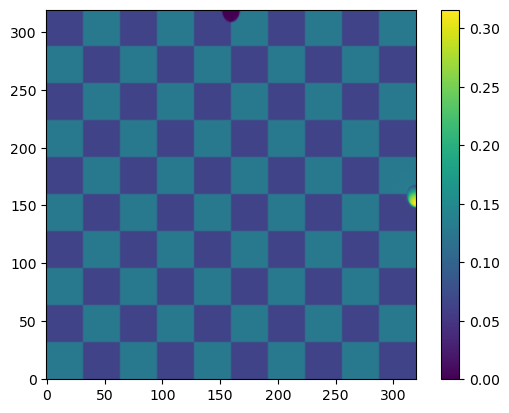

In [38]:
for sensor, title in [
    # (camera_checkerboard, "camera"),
    # (distant_beam_checkerboard, "distant_beam"),
    (distant_rectangle_checkerboard, "distant_rectangle"),
]:
    print(title)
    img = mi.Bitmap(mi.render(scene_checkerboard, sensor=sensor, spp=64))
    display(img)
    plt.imshow(np.squeeze(img), origin="lower")
    plt.colorbar()
    plt.show()

distant_rectangle


Bitmap[
  pixel_format = y,
  component_format = float32,
  size = [320, 320],
  srgb_gamma = 0,
  struct = Struct<4>[
    float32 Y; // @0, premultiplied alpha
  ],
  data = [ 400 KiB of image data ]
]

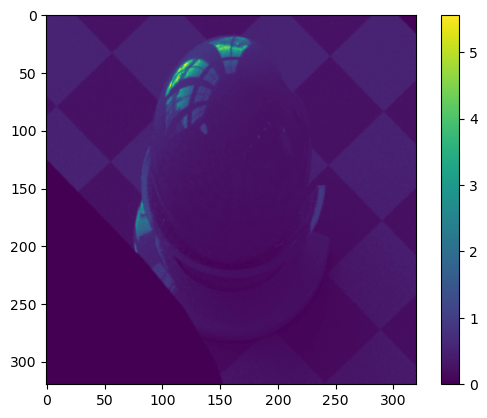

In [34]:
for sensor, title in [
    # (camera_matpreview, "camera"),
    # (distant_beam_matpreview, "distant_beam"),
    (distant_rectangle_matpreview, "distant_rectangle"),
    # (batch_distant_beam_matpreview, "batch_distant_beam")
]:
    print(title)
    img = mi.Bitmap(mi.render(scene_matpreview, sensor=sensor, spp=64))
    display(img)
    plt.imshow(np.squeeze(img))
    plt.colorbar()
    plt.show()

In [ ]:
batch_distant_beam_matpreview.film().bitmap().write("batch_distant.exr")